In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d as spline

import TwoPUtils as tpu

%matplotlib inline

In [2]:
rng = np.random.default_rng()



(1000, 1000)


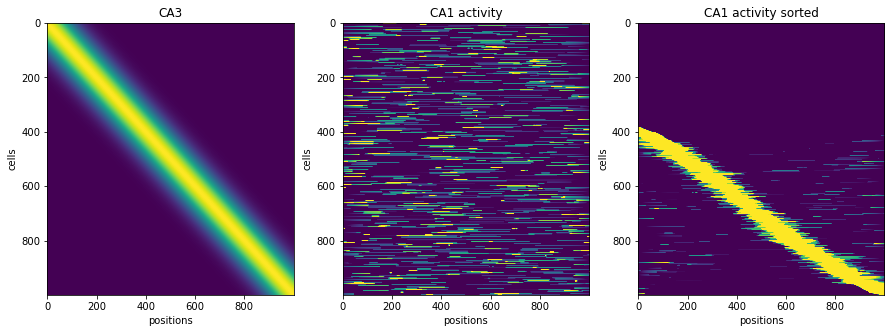

In [84]:
# repeat with radial basis funcitons
npos = 1000
pos = np.linspace(0,10,num=npos)[np.newaxis,:]


n_ca3=1000
n_ca1=1000
n_winners = 100

mu = np.linspace(0,10,num=n_ca3)[:,np.newaxis]
ca3  = tpu.utilities.gaussian(mu,1,pos) # cells by postions

w = rng.lognormal(sigma=.5, size= [n_ca1,n_ca3])

activations = np.matmul(w,ca3) 
winners = np.argsort(activations,axis=0)[::-1,:]
print(winners.shape)

ca1 = np.zeros([n_ca1,npos])
for i in range(npos):
    ca1[winners[:n_winners,i],i]=activations[winners[:n_winners,i],i]
# print(ca3.sum(axis=-1))

ca1_z = (ca1-ca1.mean(axis=-1,keepdims=True))/(np.std(ca1,axis=-1,keepdims=True)+1E-3)
fig, ax = plt.subplots(1,3, figsize=[15, 5])
ax[0].imshow(ca3, vmin=0,vmax=1, aspect='auto')
ax[0].set_title('CA3')

ax[1].imshow(ca1_z, vmin=0,vmax=1, aspect='auto')

ca1_sort = np.argsort(np.argmax(ca1,axis=-1))
ax[2].imshow(ca1_z[ca1_sort,:], vmin=0,vmax=1,aspect='auto')

ax[1].set_title('CA1 activity')
ax[2].set_title('CA1 activity sorted')

for i in range(3):
    ax[i].set_ylabel('cells')
    ax[i].set_xlabel('positions')


In [85]:


n_trials = 10
n_pos = 1000
pos = np.linspace(0,10,num=npos)[np.newaxis,:]
w_max = 100


n_ca3=1000
n_ca1=1000
n_winners = 100

eta = 1E-5
tau = 1E-5

mu = np.linspace(0,10,num=n_ca3)[:,np.newaxis]
ca3  = tpu.utilities.gaussian(mu,1,pos) # cells by postions

w = rng.lognormal(sigma=.5, size= [n_ca1,n_ca3])
ca1 = np.zeros([n_trials,n_ca1,n_pos])
for trial in range(n_trials):
    activations = np.matmul(w,ca3)
    winners = np.argsort(activations,axis=0)[::-1,:]
    for pos in range(n_pos):
        ca1[trial, winners[:n_winners,pos],pos]=activations[winners[:n_winners,pos],pos]
    w += eta*np.matmul(ca1[trial,:,:],ca3.T) 
    w = np.minimum(np.maximum(w,0),w_max)
    
    
    

23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496
23.704088164641302 0.08735816350723496


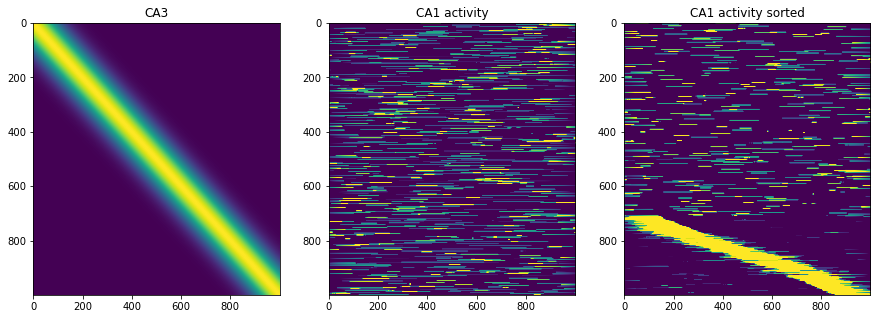

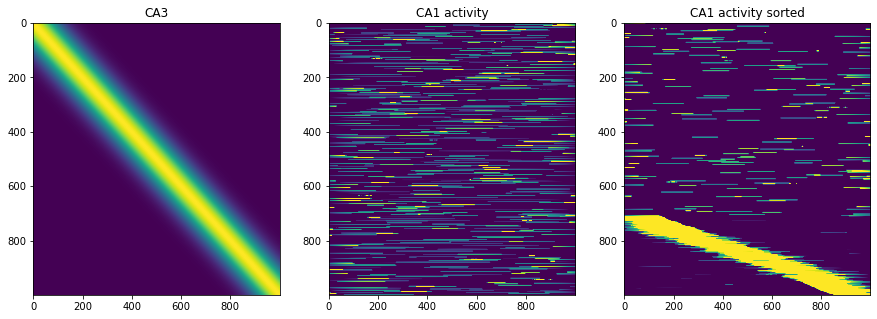

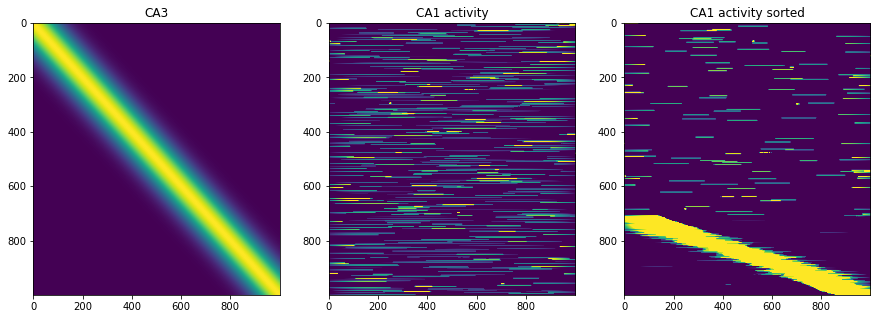

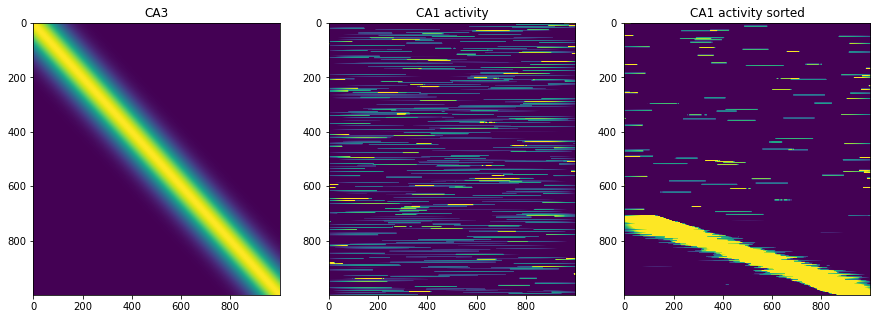

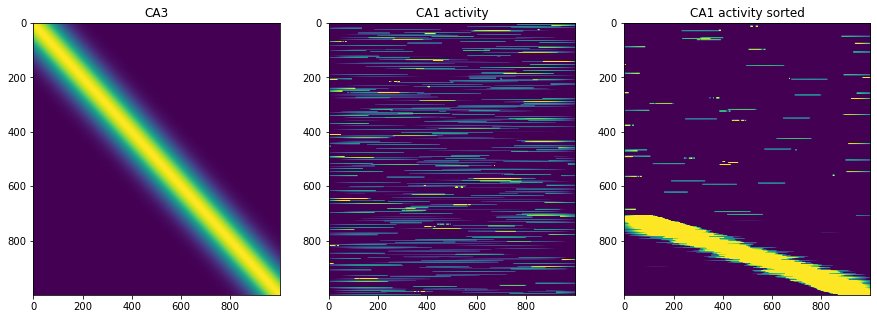

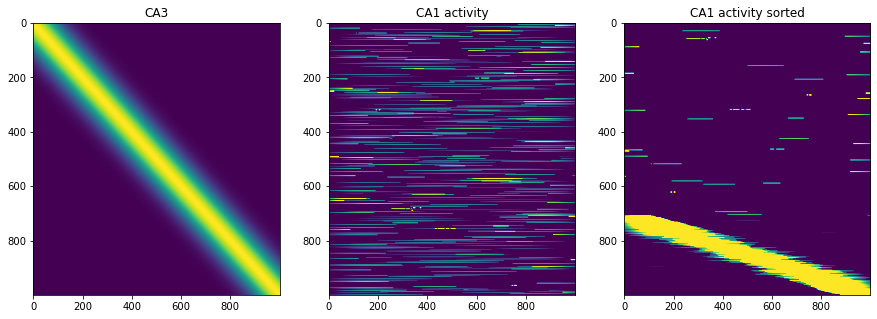

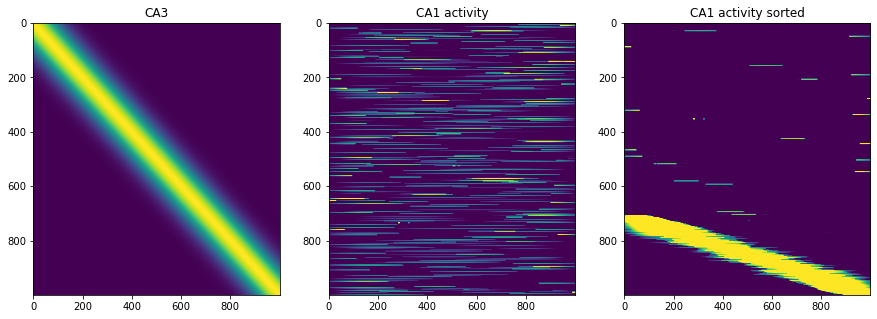

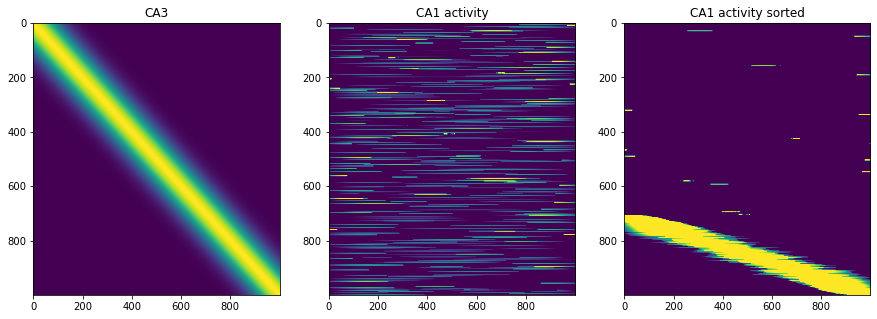

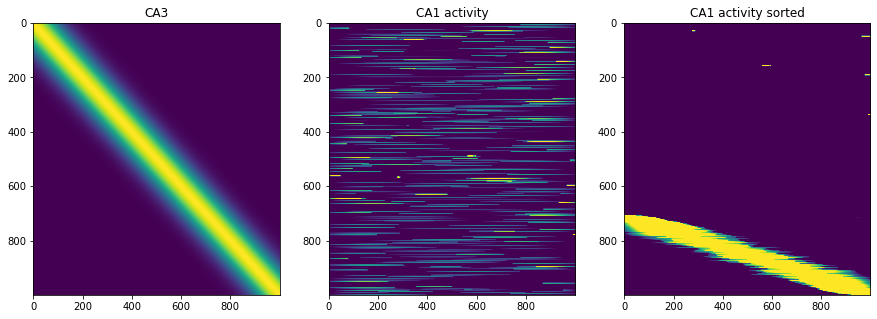

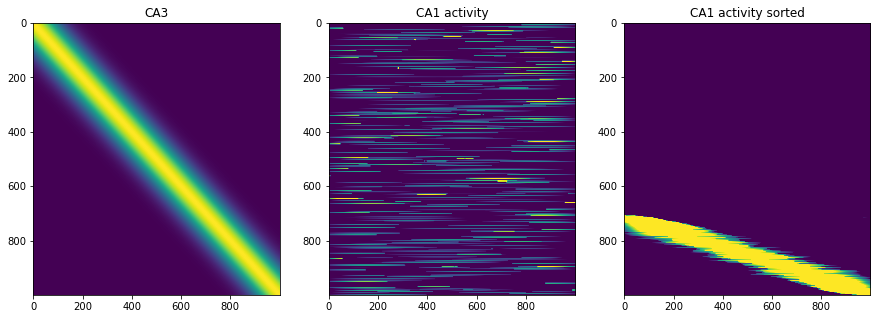

In [86]:
for trial in range(n_trials):
    ca1_z = (ca1-ca1.mean(axis=-1,keepdims=True))/(np.std(ca1,axis=-1,keepdims=True)+1E-3)
    fig, ax = plt.subplots(1,3, figsize=[15, 5])
    ax[0].imshow(ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')

    ca1_sort = np.argsort(np.argmax(ca1[-1,:,:],axis=-1))
    ax[2].imshow(ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    print(np.amax(w),np.amin(w))

In [95]:
ctrl_x = np.linspace(0,10,num=10)
ctrl_y = np.array([.1, .1, .1, .3, .7, 1, .1, .1 ,.1,.1 ])

eta_gain = spline(ctrl_x,ctrl_y)


n_trials = 10
n_pos = 1000
pos = np.linspace(0,10,num=npos)[np.newaxis,:]
w_max = 100


n_ca3=1000
n_ca1=1000
n_winners = 100

eta = 1E-5
tau = 1E-5

mu = np.linspace(0,10,num=n_ca3)[:,np.newaxis]
ca3  = tpu.utilities.gaussian(mu,1,pos) # cells by postions

w = rng.lognormal(sigma=.5, size= [n_ca1,n_ca3])
ca1 = np.zeros([n_trials,n_ca1,n_pos])
print(np.eye(n_pos).shape,eta_gain(pos).shape)
eta_gain_mat = np.eye(n_pos)*eta_gain(pos).T
print(eta_gain_mat.shape)
for trial in range(n_trials):
    activations = np.matmul(w,ca3)
    winners = np.argsort(activations,axis=0)[::-1,:]
    for pos_i in range(n_pos):
        ca1[trial, winners[:n_winners,pos_i],pos_i]=activations[winners[:n_winners,pos_i],pos_i]
    
    w += eta*np.matmul(np.matmul(ca1[trial,:,:],eta_gain_mat),ca3.T) - tau
    w = np.minimum(np.maximum(w,0),w_max)

(1000, 1000) (1, 1000)
(1000, 1000)


16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897
16.099475825074272 0.08371679836348897


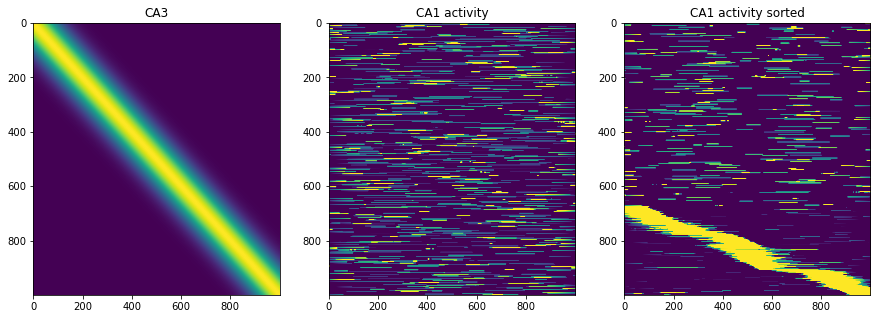

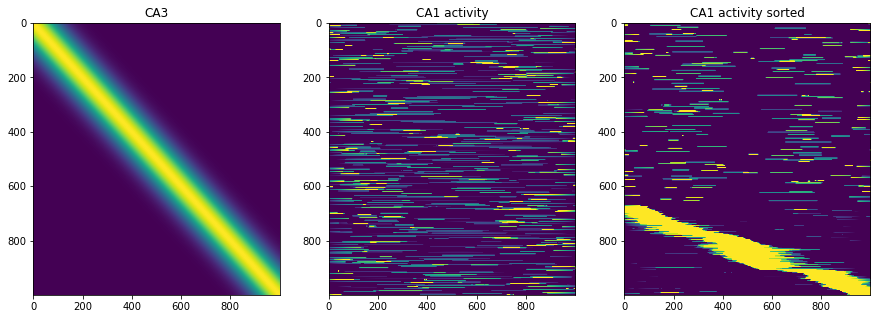

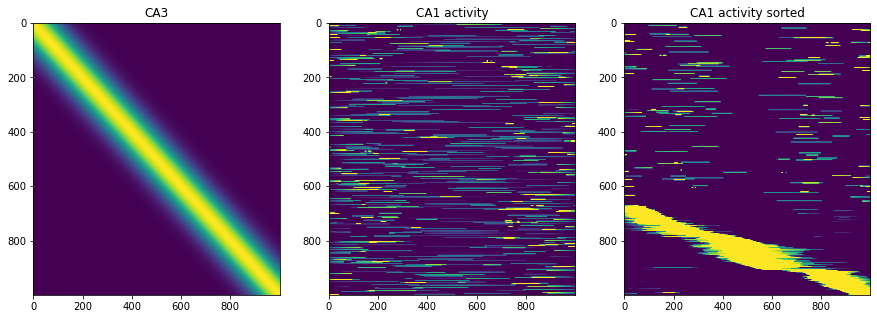

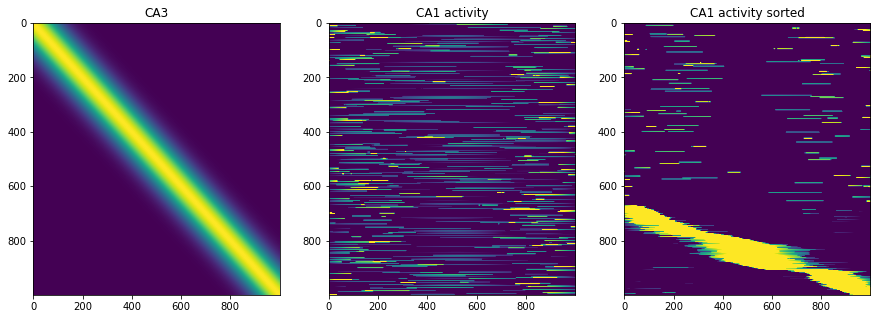

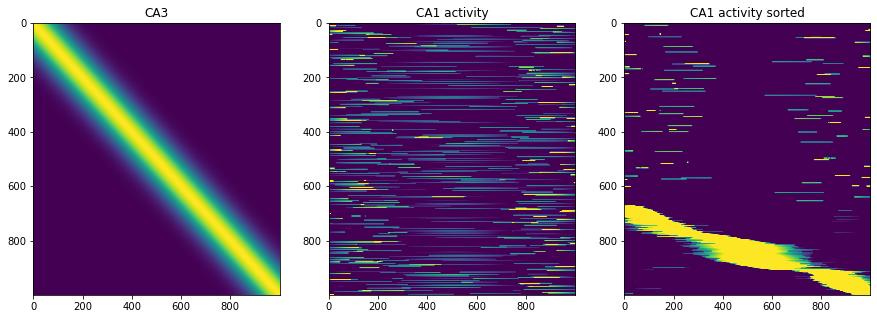

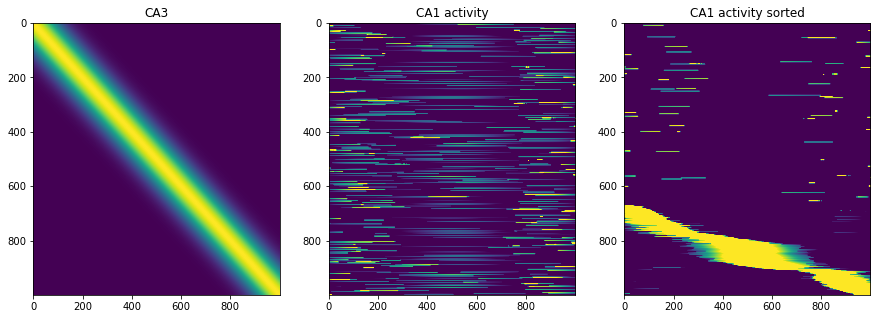

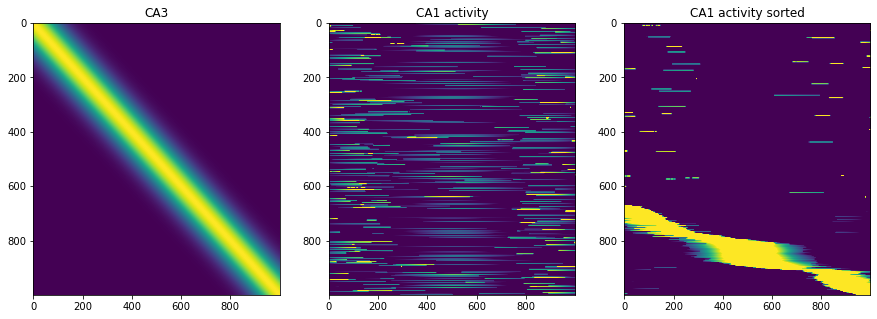

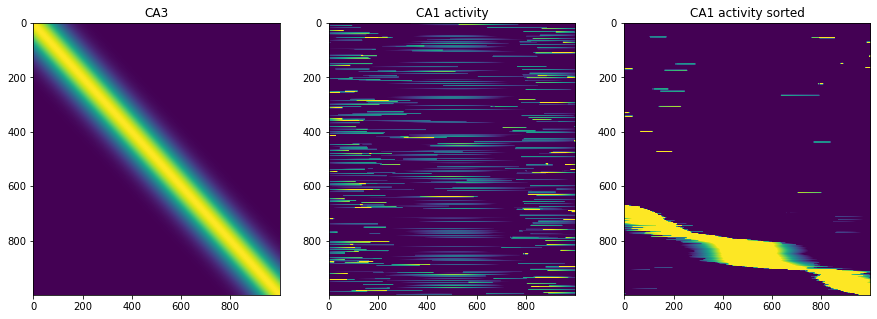

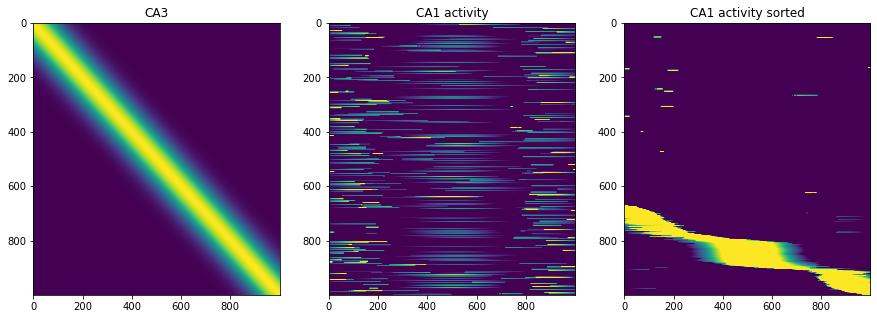

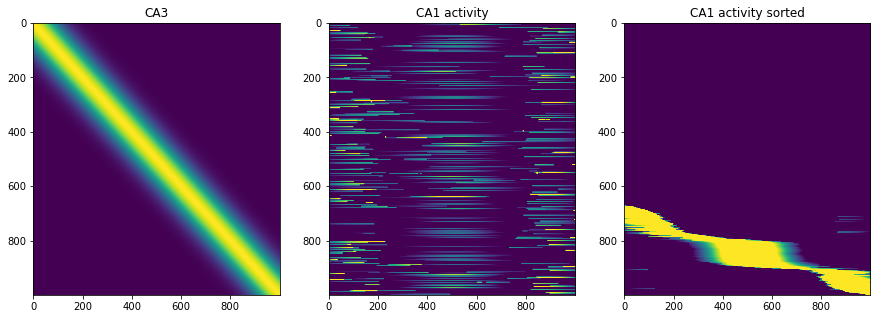

In [96]:
for trial in range(n_trials):
    ca1_z = (ca1-ca1.mean(axis=-1,keepdims=True))/(np.std(ca1,axis=-1,keepdims=True)+1E-3)
    fig, ax = plt.subplots(1,3, figsize=[15, 5])
    ax[0].imshow(ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')

    ca1_sort = np.argsort(np.argmax(ca1[-1,:,:],axis=-1))
    ax[2].imshow(ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    print(np.amax(w),np.amin(w))

In [ ]:
# add learning with a gain parameter

# uniform gain parameter vs 0 gain

# gain parameter depends on proximity to reward - aka dopamine

# homeostatic plasticity

# look for prediction of more out of field firing in the absence of LTP

# ask for example entorhinal 

# prediction that CA3 inactivated animals won't over represent reward?


In [67]:
a= np.arange(0,10)
print(np.argsort(a))

[0 1 2 3 4 5 6 7 8 9]
